# Event-related potentials

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the sample dataset
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Focus on EEG for ERP analysis
raw_eeg = raw.copy().pick_types(eeg=True)

print("Ready for ERP analysis!")
print(f"EEG channels: {len(raw_eeg.ch_names)}")
print(f"Duration: {raw_eeg.times[-1]:.1f} seconds")

Opening raw data file C:\Users\arash\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Ready for ERP analysis!
EEG channels: 59
Duration: 277.7 seconds


First, let's see what stimuli were presented to this participant:

In [ ]:
# Let's see what stimulus channels are available
print("All channel names in raw_eeg:") #Empty: means no stim channels in EEG only data
print([ch for ch in raw_eeg.ch_names if 'STI' in ch])

# Let's use the original raw data (with all channels) to find events
events = mne.find_events(raw, stim_channel='STI 014')
print(f"Found {len(events)} events")
print(f"Event types: {np.unique(events[:, 2])}") # event types are what is shown to the participant.

# Look at first few events
print("\nFirst 5 events:")
print("Time (samples) | Previous | Event ID")
for i in range(5):
    print(f"{events[i, 0]:>13} | {events[i, 1]:>8} | {events[i, 2]:>8}")

All channel names in raw_eeg:
[]
Finding events on: STI 014
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Found 319 events
Event types: [ 1  2  3  4  5 32]

First 5 events:
Time (samples) | Previous | Event ID
         6994 |        0 |        2
         7086 |        0 |        3
         7192 |        0 |        1
         7304 |        0 |        4
         7413 |        0 |        2


- Time: When the stimulus occured in sample points
- Previous: the previous event code (0 = no previous event)
- Event ID: Type of stimulus presented to the particpant. 

Given from these 5 first events, we might conclude that event types 5 & 32 are practice trials or different conditions. 

In [ ]:
# Count each event type
print("\nEvent counts:")
for event_type in np.unique(events[:, 2]):
    count = np.sum(events[:, 2] == event_type)
    print(f"Event {event_type}: {count:3} occurrences")

#For ERP analysis, let's focus on the most common events, in this case that is 1-5 (see occurences below)
main_events = events[np.isin(events[:, 2], [1, 2, 3, 4, 5])]
print(f"\nMain experimental events (1-5): {len(main_events)} total")


Event counts:
Event 1:  72 occurrences
Event 2:  73 occurrences
Event 3:  73 occurrences
Event 4:  70 occurrences
Event 5:  15 occurrences
Event 32:  16 occurrences

Main experimental events (1-5): 303 total


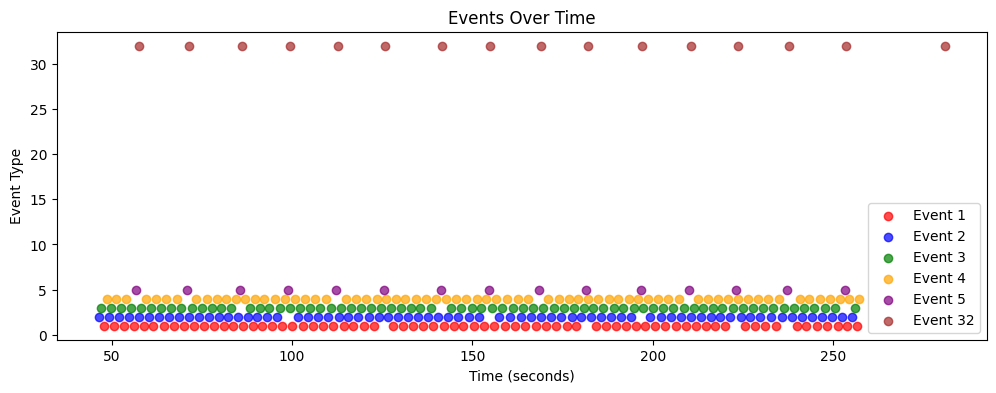

In [7]:
# Let's just work with the events we found without assuming their meaning
# Plot the events over time to see patterns
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
event_types = np.unique(events[:, 2])

for i, event_type in enumerate(event_types):
    event_times = events[events[:, 2] == event_type, 0] / raw.info['sfreq']
    ax.scatter(event_times, [event_type] * len(event_times), 
              color=colors[i % len(colors)], label=f'Event {event_type}', alpha=0.7)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Event Type')
ax.set_title('Events Over Time')
ax.legend()
plt.show()

Now let's create epochs, time-locked segments around echt stimulus, and see the brain's response:

In [11]:
# Now let's create epochs using our EEG data and events
# Define our event dictionary for two conditions
event_dict = {'condition_1': 1, 'condition_2': 2}


print("Creating epochs for ERP analysis:")

# -0.2 to 0.5 seconds around each stimulus (typical for ERPs)
epochs = mne.Epochs(raw_eeg, events, event_dict, 
                   tmin=-0.2, tmax=0.5,
                   baseline=(None, 0),
                   preload=True)

print(f"\nCreated epochs:")
print(f"Total epochs: {len(epochs)}")
print(f"Time range: {epochs.tmin} to {epochs.tmax} seconds") 
print(f"Sampling rate: {epochs.info['sfreq']} Hz") 

Creating epochs for ERP analysis:
Not setting metadata
145 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 145 events and 106 original time points ...
0 bad epochs dropped

Created epochs:
Total epochs: 145
Time range: -0.19979521315838786 to 0.49948803289596966 seconds
Sampling rate: 150.15374755859375 Hz


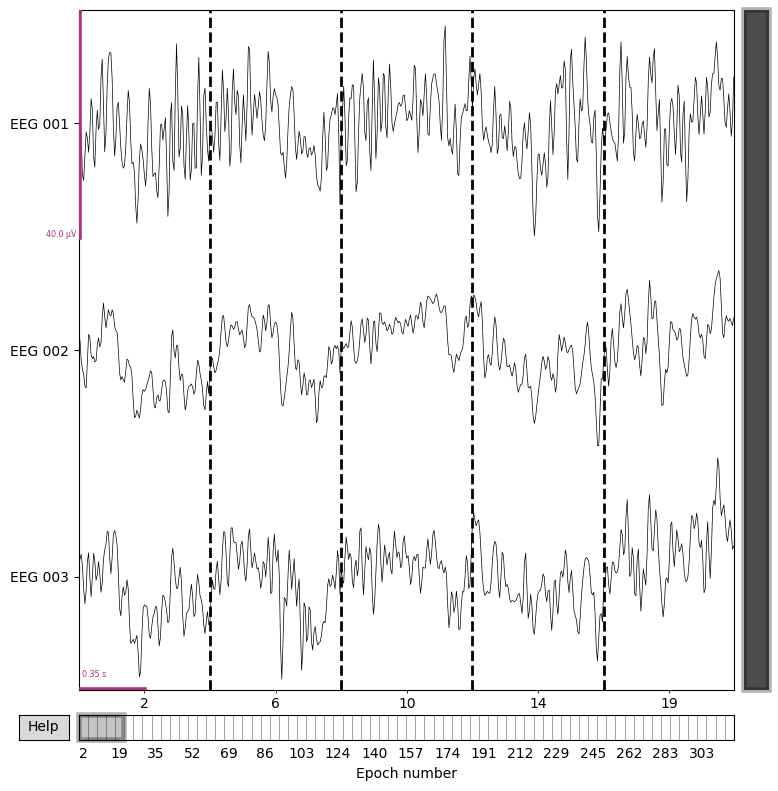

In [ ]:
# Plot a few individual epochs to see the raw responses
epochs['condition_1'].plot(picks=['EEG 001', 'EEG 002', 'EEG 003'], # select a few channels
                          n_epochs=5, title='Individual Epochs - Condition 1') # plot 5 epochs
plt.show()

- Each epoch shows the raw brain response to one stimulus
- the vertical dashed line shows time 0, when the stimulus was presented to the participant

ERP Analysis:


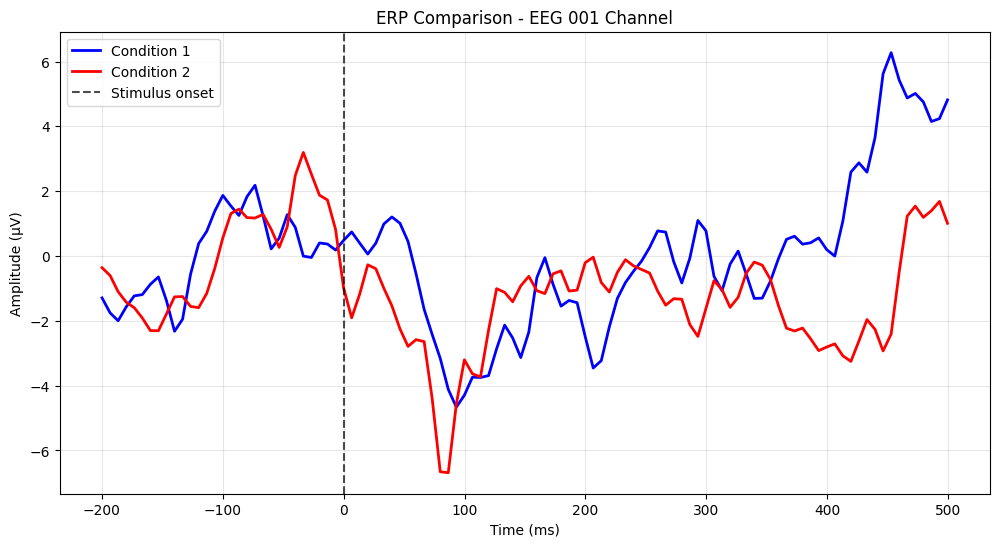

In [17]:
# Create ERPs by averaging across trials
evoked_1 = epochs['condition_1'].average()
evoked_2 = epochs['condition_2'].average()

print("ERP Analysis:")

# Compare conditions on the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Get the data for one channel to compare
times = evoked_1.times * 1000  # Convert to milliseconds
data_1 = evoked_1.get_data(picks=['EEG 001'])[0] * 1e6  # Convert to microvolts
data_2 = evoked_2.get_data(picks=['EEG 001'])[0] * 1e6

# Plot both conditions
ax.plot(times, data_1, label='Condition 1', color='blue', linewidth=2)
ax.plot(times, data_2, label='Condition 2', color='red', linewidth=2)
ax.axvline(0, color='black', linestyle='--', alpha=0.7, label='Stimulus onset')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (μV)')
ax.set_title('ERP Comparison - EEG 001 Channel')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

- Blue line (Condition 1): Average brain response across all 72 trials of event type 1
- Red line (Condition 2): Average brain response across all 73 trials of event type 2

Before the stimulus you can see the baseline brain activity. at around 100 ms we see the initial processing of the stimulus. all subsequent components are higher-level cognitive processes. 

Both stimuli require a different brain response, which is clear from the graph. 

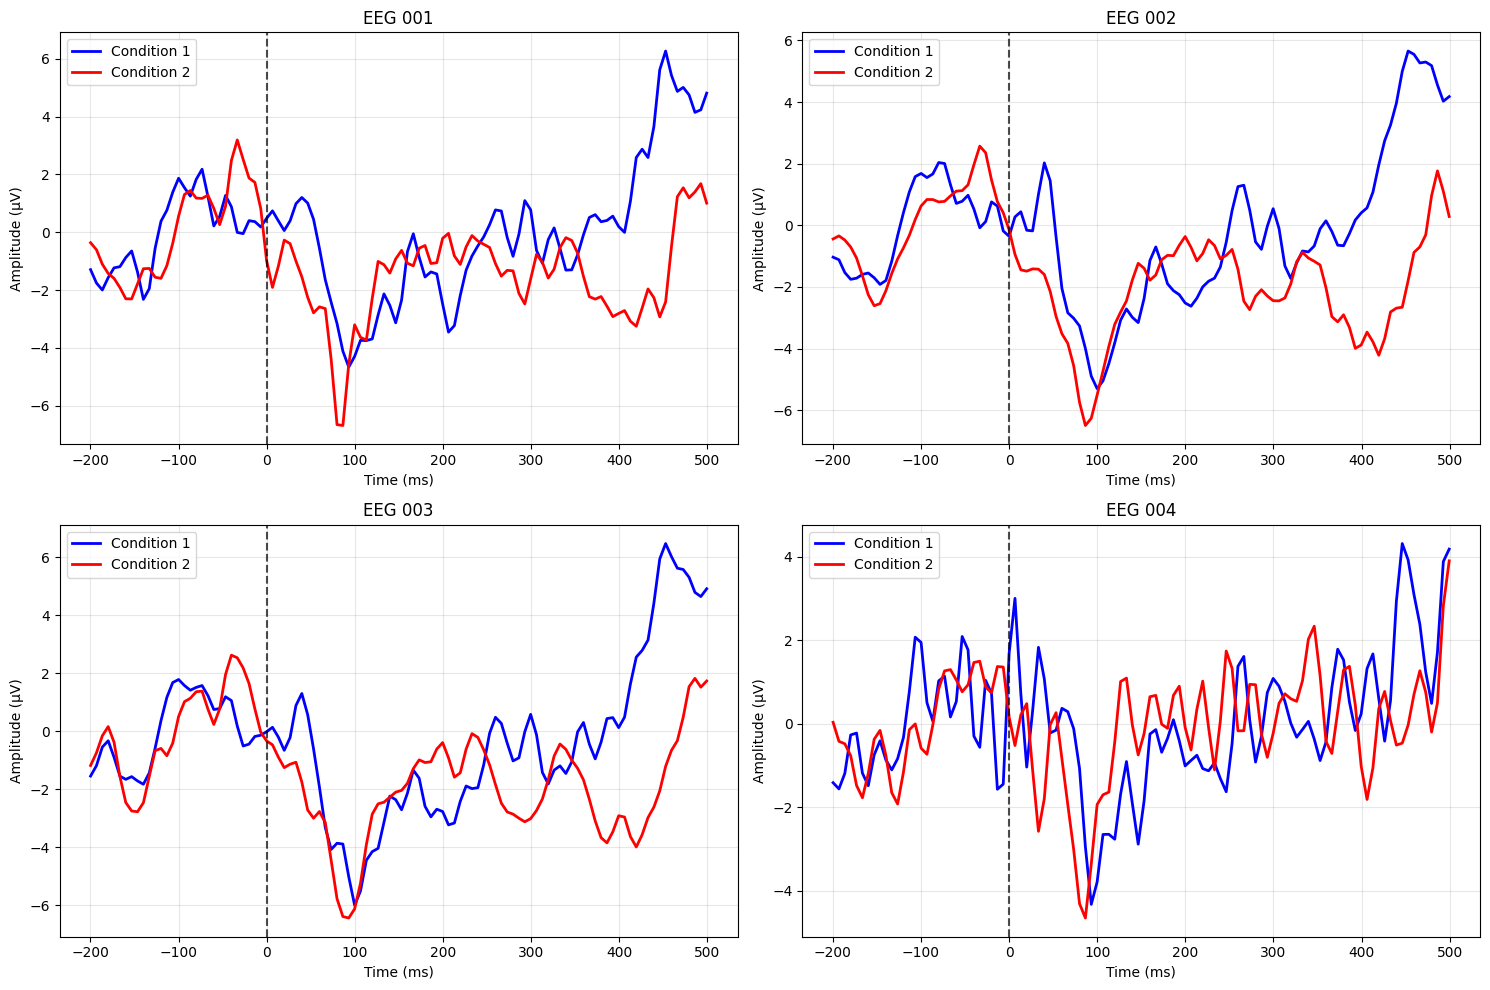

In [18]:
# Let's explore more channels to see the full picture
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
channels = ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004']

for i, ch in enumerate(channels):
    ax = axes[i//2, i%2]
    times = evoked_1.times * 1000
    data_1 = evoked_1.get_data(picks=[ch])[0] * 1e6
    data_2 = evoked_2.get_data(picks=[ch])[0] * 1e6
    
    ax.plot(times, data_1, 'b-', label='Condition 1', linewidth=2)
    ax.plot(times, data_2, 'r-', label='Condition 2', linewidth=2)
    ax.axvline(0, color='black', linestyle='--', alpha=0.7)
    ax.set_title(f'{ch}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

so different brain regions respond differently to the same stimuli!